# Managing Battery Storage under Price Uncertainty

Let us consider a simple model of a battery storage system that is connected to the grid but not used to supplement a smart home. An optimal decision policy would try to buy electricity when the price is low and sell electricity when the price is high. We use the following notation:

|Symbol|Description|
|---|---|
|$t$|time index|
|$s$|power held in storage|
|$c$|charge|
|$d$|discharge|
|$q$|power loss|
|$K$|storage capacity|
|$C$|power capacity|
|$p_t$|random price|
|$P_t$|price history up to $t-1$|

The decision-maker seeks to find an optimal policy that maximizes our expected rewards from emptying and filling our battery storage device. A mathematical model that describes this decision problem as a so-called multistage stochastic optimization problem would look as follows.

$$\begin{align}\max\ & \mathbb{E}\left[ \sum_{t=1}^T p_t(d_t(P_t) -c_t(P_t)) \right]  \\
s.t.\ & s_t(P_t) = s_{t-1}(P_t) + q c_t(P_t) - d_t(P_t), \ t=1,...,T \\
& 0 \leq s_t(P_t) \leq K,\ t=1,...,T \\
& 0 \leq c_t(P_t) \leq C,\ t=1,...,T \\
& 0 \leq d_t(P_t) \leq C,\ t=1,...,T.
\end{align}$$

We now use QUASAR stochastic optimizer to model, solve, and analyze this optimization problem. The optimizer can be accessed through a Python library which must be imported first.

In [1]:
%config InlineBackend.figure_format = 'retina'
from pyquasar import *

### The Decision Problem
First, we must first define a couple of parameters 

In [2]:
num_hours = 24
power_loss = 0.8
storage_capacity = 100
power_capacity = 25
initial_storage  = 0

Since we have a sequential decision problem, we make the same type of decisions in each hour. We will therefore loop over all periods in our decision problem, which in this case has 24 hours. 

In [3]:
model = DecisionProblem()

for t in range(num_hours):
    
    # decision variables
    final_storage, charge, discharge = model.add_variables(t, "storage", "charge", "discharge")

    # storage balance
    model += final_storage == initial_storage + power_loss*charge - discharge

    # storage limits
    model += final_storage <= storage_capacity
    model += charge <= power_capacity
    model += discharge <= power_capacity
    
    # reward function
    model += rand("price") * (discharge - charge)
    
    # assign storage to previous_storage for next loop
    initial_storage = final_storage

### The Stochastic Process

Let us use a very simple first-order autoregressive model to express the electricity price. In an autoregressive model, the electricity price will depend on past prices. This is also what we are likely to encounter in real data, as it is unlikely that the price will randomly oscillate from one hour to the next.

Recall that $p_t$ has been defined as the random price at stage $t$. Let $\varepsilon_t$ be a normally distributed random variable with mean $\mu_t$ and variance $\sigma_t^2$. With $\phi_i$ being the weight of the price of the previous hour,  the first-order autoregressive model of the price is given by

$$p_t = \mu_t + \phi p_{t-1} + \varepsilon_t.$$

To pass this into QUASAR, we must define the parameters of the price process an then create a new v<code>ARModel</code> that contains the stochastic process.

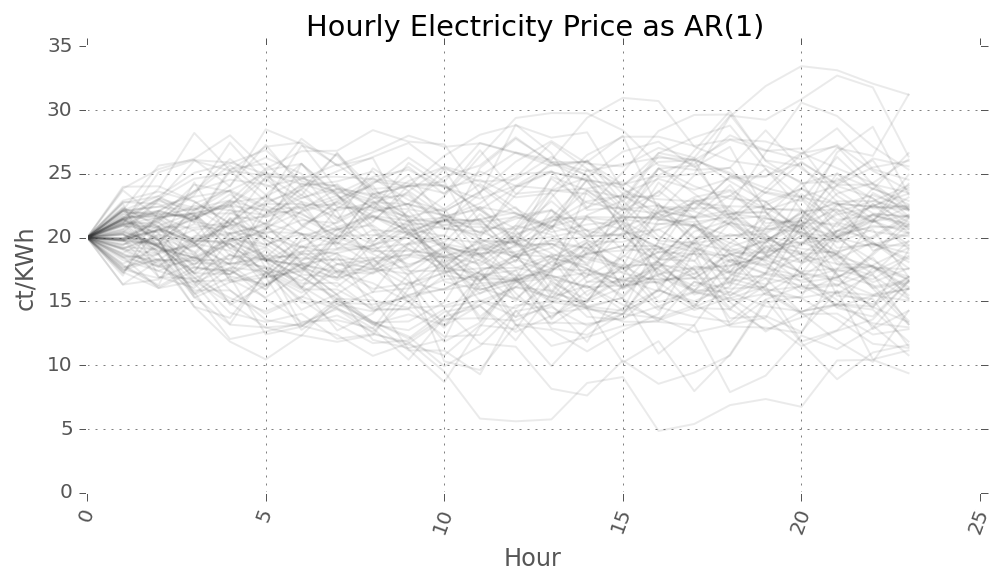

In [4]:
name ="price"; mu=2;  sigma=2;  phi=[0.9];  initial_price=[20]
price_process = ARModel(name,
                  constant=mu, 
                  sigma=sigma, 
                  ar_coefficients=phi, 
                  initial_state=initial_price)
sample = price_process.simulate(num_stages=num_hours, sample_size=100)
sample.price.spaghetti(title='Hourly Electricity Price as AR(1)', ylabel='ct/KWh', xlabel='Hour')

### Solving the Stochastic Decision Problem
To solve the stochastic decision problem to optimality we will use QUASAR's dynamic optimizer. For most stochastic optimization problems like the one above, the true optimum cannot be found. Rather it is common to find an approximate solution that comes close to the optimum.

The dynamic optimizer automatically computes an approximation of the optimal decision policy. Internally, it approximates the stochastic process by using a small set of discrete price states called nodes. The quality of the approximation largely depends on how many of these nodes there are and how they are being selected. The optimizer handles these steps automatically. However, it is always a good idea to manually adjust the number of nodes to see if the quality of the approximation is changing. In most cases, the default setting will be sufficient.

The optimizer is started by calling

In [5]:
opt = DynamicOptimizer(model, price_process, num_nodes=20)
opt.solve()
opt.join()

Once the optimizer is finished, we can obtain the solution which takes the form of a policy, <code>opt.policy</code>. This policy can be simulated, much like the stochastic process has been simulated.

In [6]:
policy = opt.policy
solution = policy.simulate(sample_size = 1000, process = price_process)

### Analyzing the Simulation Output
The <code> solution </code> holds all simulated sample paths of the optimal policy as a Pandas DataFrame, containing the values of each decision variable as well as the values of the random variable, but also the reward at each stage and the shadow prices of the time-coupling variables which can be used for some advanced decision analyses. 

Much like with the price process, the time series of the decision variables can also be visualized. Spaghetti plots of charges and discharges, for example show that we charge mostly during the beginning and discharge mostly during the end. This seems reasonable given the system starts out empty and the model provides no incentive to keep anything in storage at the end of the day.


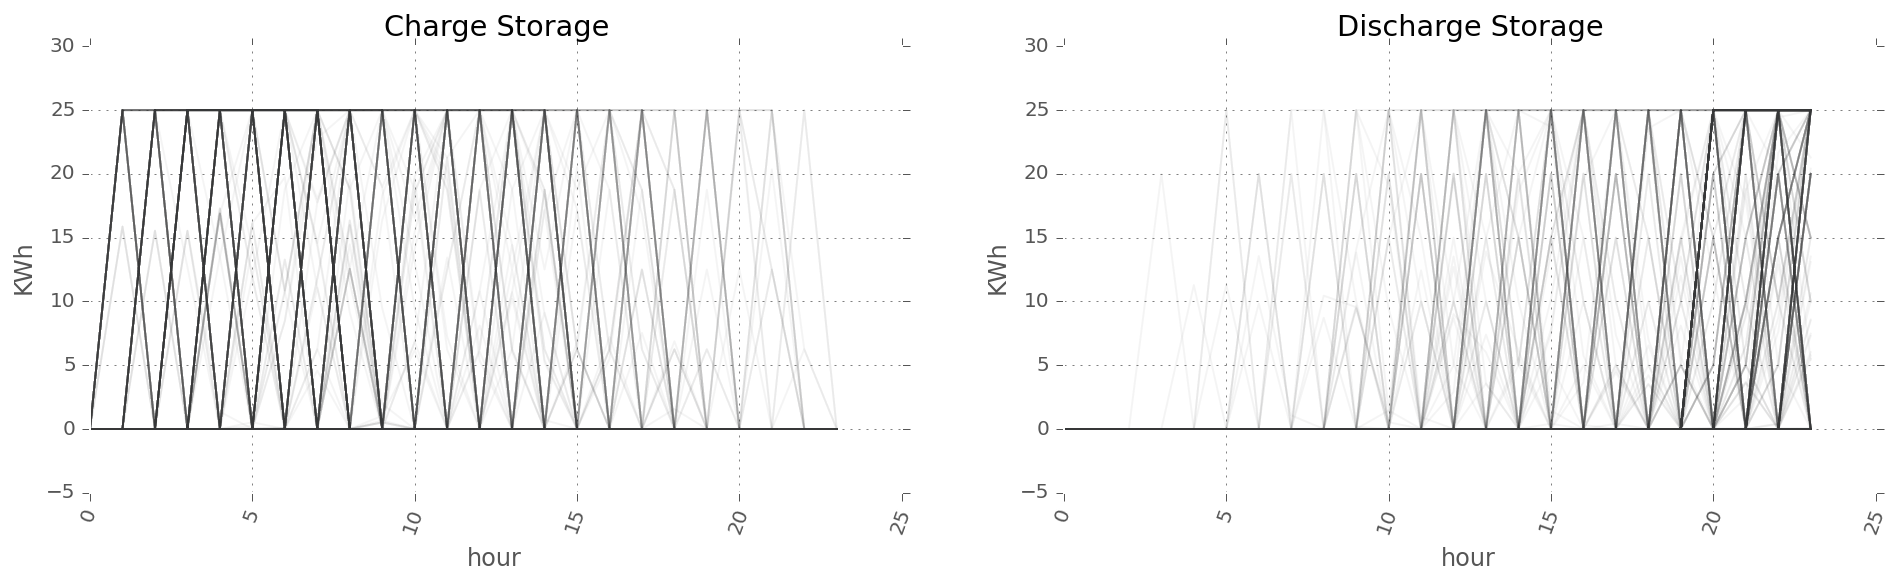

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
solution.decision['charge'].spaghetti(ax1, alpha=.05, title='Charge Storage', ylabel='KWh', xlabel='hour')
solution.decision['discharge'].spaghetti(ax2, alpha=.05, title='Discharge Storage', ylabel='KWh', xlabel='hour')

We can also look at how storage levels and the marginal value of storage develop over time by looking at fan charts of the storage levels as well as their shadow prices. We can see that the storage tends to be empty towards the beginning and towards the end which is not surprising given the distribution of charge and discharge decision. It is also interesting to see that the value of stored electricity is 10 percent higher than the price of electricity.


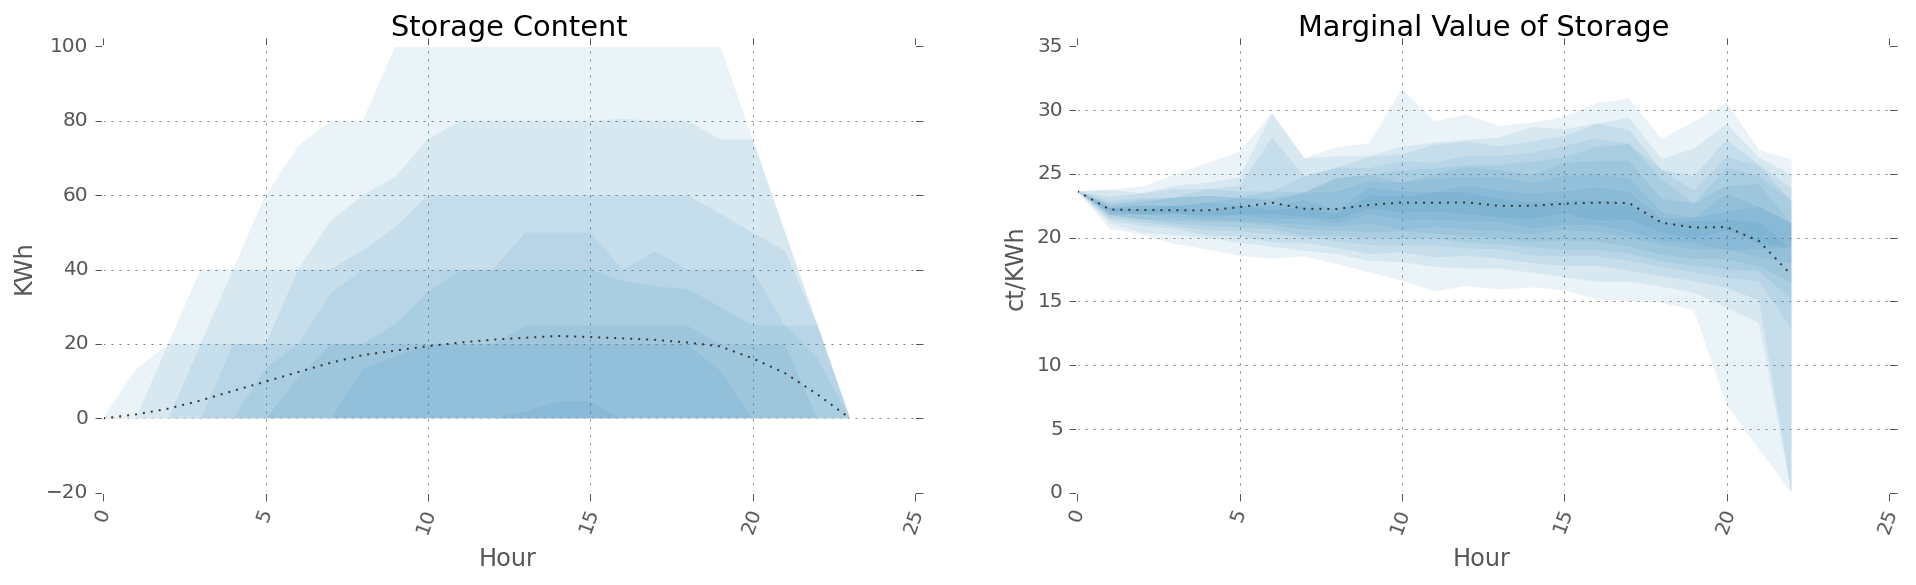

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
solution.decision['storage'].fanchart(ax1, title='Storage Content', ylabel='KWh', xlabel='Hour')
solution.shadow_price['storage'].fanchart(ax2, title='Marginal Value of Storage', ylabel='ct/KWh', xlabel='Hour')

Of course we can also look at the distribution of the total rewards that accumulate over the 24-hour period. Since we are dealing with a Pandas DataFrame, we can obtain a descriptive statistics of the 24-hour value of our battery storage by calling

In [10]:
solution.rewards.groupby_series.sum().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rewards,1000.00,39.44,182.34,-912.85,-0.00,0.00,90.35,987.19


The reward distribution can also be visualized, for example as a histogram or as a box plot.

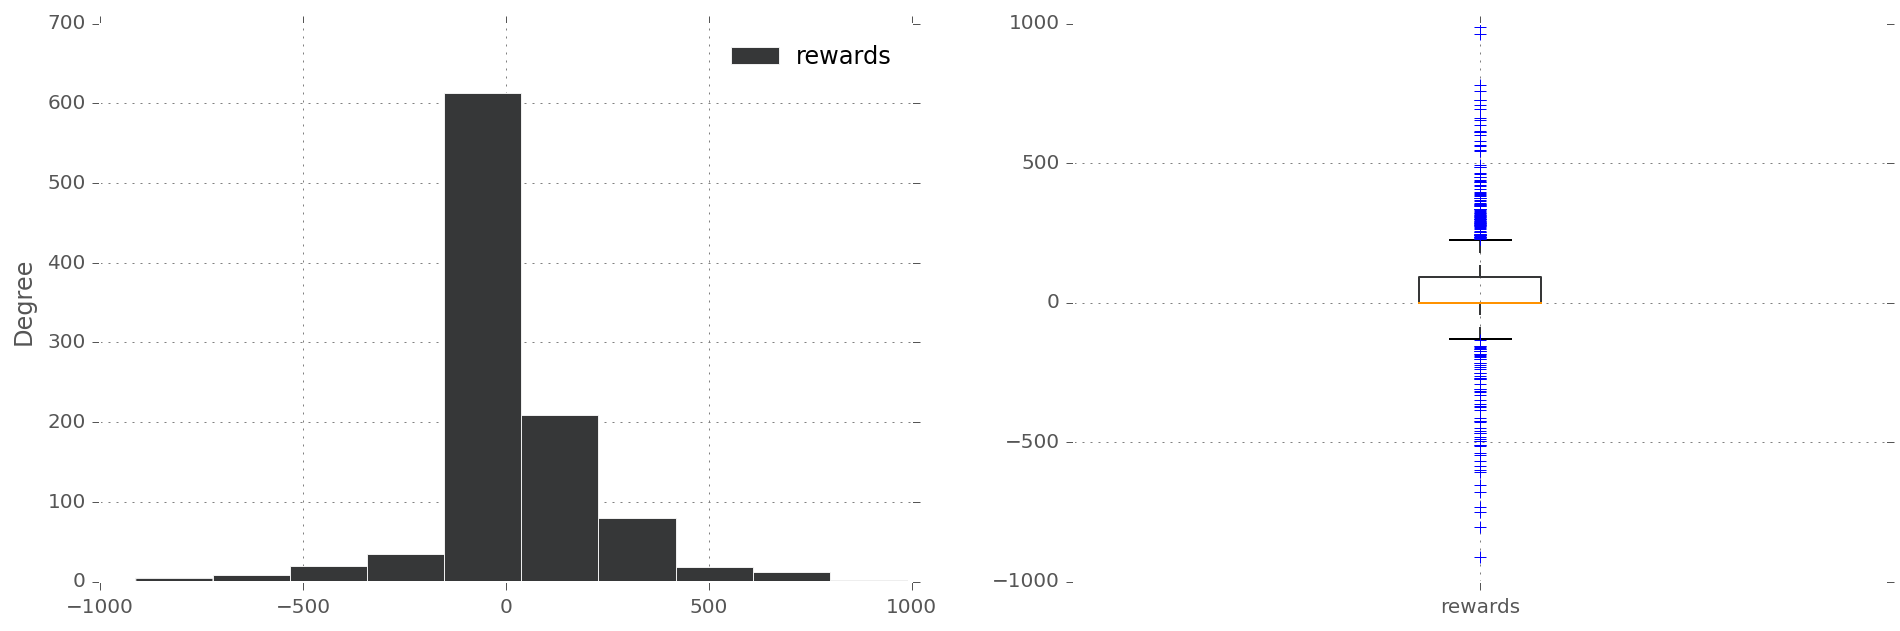

In [13]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,5))
solution.rewards.groupby_series.sum().plot(kind='hist',ax=ax1)
solution.rewards.groupby_series.sum().boxplot(ax=ax2)

Since everything is in Pandas, we can also run some more advanced decision analyses. For example, it could be interesting to learn about the minimum or maximum price at which the storage is being charged or discharged, in particular at intermediate stages, where the policy is more likely to be in steady-state.


In [14]:
print 'Sell at %.2f'%solution.query('stage==12')[solution.decision['discharge']>1.e-4].state.price.min()
print 'Buy at %.2f'%solution.query('stage==12')[solution.decision['charge']>1.e-4].state.price.max()

Sell at 21.25
Buy at 15.09


This information can now be used to derive a decision rule which can be used to provide a battery storage with a simple control policy. 